In [2]:
import pandas as pd
import os
import numpy as np
from matplotlib import pylab as plot
%matplotlib inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

Загрузим тренировочный датасет, датасет, по которому нужно сделать предсказания, и датасет, содержащий 'id' предсказываемых действий 

In [3]:
# Загружаем датасеты
df_train = pd.read_csv('data/df_events_epl_train.csv', low_memory=False) # тренировочный
df_predict = pd.read_csv('data/df_events_bundes_test.csv', low_memory=False) # предсказываемый

submission_result = pd.read_csv('data/sample_submission.csv', low_memory=False) # 'id' предсказываемых действий

Предсказывать успешность паса будем с помощью следующих метрик:
1. Начало и конец паса (x и y координаты)
2. Длина паса
3. Угол паса
4. Высота паса ('Ground Pass', 'Low Pass', 'High Pass')
5. Часть тела, которой сделан пас ('Drop Kick', 'Head', 'Keeper Arm', 'Left Foot', 'Other', 'Right Foot', 'No Touch', 'NaN')
6. Тип паса ('Recovery', 'Interception', 'NaN')
7. Длительность паса
8. Был ли пас под прессингом

Подготовим обучающий датасет:
1. Возьмём из df_train только те строки, где 'type_name' = 'Pass'
2. Удалим из полученных датасетов строки, для которых 'pass_type_name' равен 'Kick Off', 'Throw-in', 'Goal Kick','Free Kick', 'Corner'
3. Удалим из полученных датасетов строки, для которых 'pass_outcome_name' равен 'Pass Offside', 'Injury Clearance', 'Unknown'
4. Удалим строки, где 'pass_miscommunication' = 'True' (пас точно не был успешен, но не из-за метрик паса, поэтому эти данные можно считать выбросом)

In [4]:
# Берём строки, обозначающие пас
df_train = df_train[(df_train['type_name'] == 'Pass')]

In [5]:
# Убираем ненужные строки
df_train = df_train[~df_train['pass_type_name'].isin(['Kick Off', 'Throw-in', 'Goal Kick', 'Free Kick', 'Corner'])]
df_train = df_train[~df_train['pass_outcome_name'].isin(['Pass Offside', 'Injury Clearance', 'Unknown'])]
df_train = df_train[~(df_train['pass_miscommunication'] == True)]

Теперь составим X и y из нужных столбцов. Напишем функцию, которая будет составлять правильные датафреймы

In [6]:
# Функция, которая преобразует исходный датасет в нужный для решения задачи
def set_X(df):
    # Устанавливаем столбцы и их названия
    data = {
        'pass_start_location_x': df['location_0'],
        'pass_start_location_y': df['location_1'],
        'pass_end_location_x': df['pass_end_location_0'],
        'pass_end_location_y': df['pass_end_location_1'],
        'pass_length': df['pass_length'],
        'pass_angle': df['pass_angle'],
        'pass_height_name': df['pass_height_name'],
        'pass_body_part_name': df['pass_body_part_name'],
        'pass_type_name': df['pass_type_name'],
        'under_pressure': df['under_pressure'],
        'duration': df['duration']
    }
    X = pd.DataFrame(data)
    
    # Так как есть столбцы не с числовыми значениями, сделаем one-hot кодирование
    X = pd.get_dummies(X)
    X.columns = [c.replace(' ', '_') for c in X.columns]
    
    return X

In [7]:
X = set_X(df_train)

# Цель обучения -- предсказать столбец 'outcome_binary'
y = df_train['outcome_binary']

Разделим выборку на тестовую и тренировочную

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [9]:
X_train

,pass_start_location_x,pass_start_location_y,pass_end_location_x,pass_end_location_y,pass_length,pass_angle,duration,pass_height_name_Ground_Pass,pass_height_name_High_Pass,pass_height_name_Low_Pass,pass_body_part_name_Drop_Kick,pass_body_part_name_Head,pass_body_part_name_Keeper_Arm,pass_body_part_name_Left_Foot,pass_body_part_name_No_Touch,pass_body_part_name_Other,pass_body_part_name_Right_Foot,pass_type_name_Interception,pass_type_name_Recovery,under_pressure_True
552373,65.0,46.9,54.3,37.3,14.375326,-2.410329,1.187925,1,0,0,0,0,0,0,0,0,1,0,0,0
496901,13.7,36.9,17.6,22.1,15.305228,-1.313140,1.618963,1,0,0,0,0,0,0,0,0,1,0,0,0
177066,5.4,42.4,18.3,56.9,19.407730,0.843726,2.761846,1,0,0,0,0,0,0,0,0,1,0,0,0
1043847,91.4,46.8,84.1,49.2,7.684400,2.823957,0.542548,1,0,0,0,0,0,1,0,0,0,0,0,0
448928,95.5,73.9,79.7,75.4,15.871043,3.046940,1.681377,1,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462931,45.3,24.6,55.4,9.1,18.500270,-0.993288,1.153043,1,0,0,0,0,0,0,0,0,1,0,0,0
1004304,42.0,20.7,51.8,23.6,10.220078,0.287708,1.283266,0,0,1,0,0,0,0,0,0,1,0,0,0
510870,79.6,18.5,80.0,34.1,15.605127,1.545161,1.078043,0,0,1,0,0,0,0,0,0,0,0,1,1
567146,17.3,56.2,21.9,74.2,18.578482,1.320596,1.157126,1,0,0,0,0,0,0,0,0,1,0,0,0


In [10]:
y_train

552373     1.0
496901     1.0
177066     1.0
1043847    1.0
448928     1.0
          ... 
462931     1.0
1004304    1.0
510870     0.0
567146     1.0
471317     1.0
Name: outcome_binary, Length: 275004, dtype: float64

Посмотрим, сбалансированная ли получилась тренировочная выборка

In [11]:
y_train.value_counts(normalize=True)

1.0    0.819799
0.0    0.180201
Name: outcome_binary, dtype: float64

Очень не сбалансированная. Тогда сразу подберём гиперпараметер scale_pos_weight

In [12]:
total_positive = y_train[y_train == 1.0].shape[0]
total_positive

225448

In [13]:
total_negative = y_train[y_train == 0.0].shape[0]
total_negative

49556

In [14]:
scale_pos_weight = total_negative / total_positive
scale_pos_weight

0.2198112203257514

In [15]:
from sklearn import metrics

# Функция для моделирования и кросс-валидации
def modelfit(alg, X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xg_train = xgb.DMatrix(X_train.values, label = y_train.values)
        xg_test = xgb.DMatrix(X_test.values)
        # Кросс-валидация.
        cvresult = xgb.cv(xgb_param, xg_train, num_boost_round = alg.get_params()['n_estimators'], nfold = cv_folds,
                          metrics = 'auc', early_stopping_rounds = early_stopping_rounds) 
        alg.set_params(n_estimators = cvresult.shape[0])
    
    # Fit the algorithm on the data.
    alg.fit(X_train, y_train, eval_metric = 'auc')
        
    # Predict training set.
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
        
    # Print model report.
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    
    # Predict on testing data.
    X_test['predprob'] = alg.predict_proba(X_test)[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(y_test, X_test['predprob']))
    
    # Важность признаков.
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending = False)
    feat_imp.plot(kind = 'bar', title = 'Feature Importances')
    plot.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8696
AUC Score (Train): 0.939105
AUC Score (Test): 0.937762


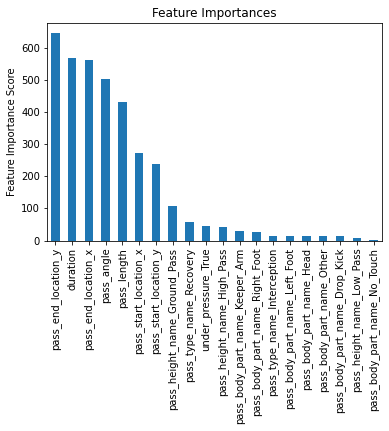

In [16]:
# Первоначальные параметры зададим такими:
xgb1 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 150,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = scale_pos_weight,
    seed = 27,
    use_label_encoder = False)
modelfit(xgb1, X_train, X_test, y_train, y_test)

X_test = X_test.drop([x for x in ['predprob'] if x in X_test.columns], axis=1)

Подберём гиперпараметры

In [18]:
from sklearn.model_selection import GridSearchCV

# Начнём с самых значимых: max_depth и min_child_weight
param_test_1 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}
gsearch_1 = GridSearchCV(estimator = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 150,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = scale_pos_weight,
    seed = 27,
    use_label_encoder = False), param_grid = param_test_1, scoring = 'roc_auc', n_jobs = 4, cv=5)

gsearch_1.fit(X_train, y_train)

[01:09:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None,
                

In [20]:
list(zip(gsearch_1.cv_results_['mean_test_score'], gsearch_1.cv_results_['params']))

[(0.9285780521898029, {'max_depth': 3, 'min_child_weight': 1}),
 (0.9287053498982798, {'max_depth': 3, 'min_child_weight': 3}),
 (0.9285108086762133, {'max_depth': 3, 'min_child_weight': 5}),
 (0.9352466444690414, {'max_depth': 5, 'min_child_weight': 1}),
 (0.9351640747395228, {'max_depth': 5, 'min_child_weight': 3}),
 (0.9352868217771373, {'max_depth': 5, 'min_child_weight': 5}),
 (0.9368657600623564, {'max_depth': 7, 'min_child_weight': 1}),
 (0.9368523610969222, {'max_depth': 7, 'min_child_weight': 3}),
 (0.9369472772169839, {'max_depth': 7, 'min_child_weight': 5}),
 (0.9370392115574026, {'max_depth': 9, 'min_child_weight': 1}),
 (0.9369540447063234, {'max_depth': 9, 'min_child_weight': 3}),
 (0.9371717291840639, {'max_depth': 9, 'min_child_weight': 5})]

In [21]:
print('The best parameters:', gsearch_1.best_params_)
print('The best score:', gsearch_1.best_score_)

The best parameters: {'max_depth': 9, 'min_child_weight': 5}
The best score: 0.9371717291840639


Попробуем улучшить модель, взяв эти же параметры в окрестностях полученных лучших результатах. Т.е. 'max_depth' будем менять в окрестностях 9, а 'min_child_weight' в окрестностях 5

In [23]:
param_test_2 = {
    'max_depth': [8, 9, 10, 11],
    'min_child_weight': [4, 5, 6, 7]
}
gsearch_2 = GridSearchCV(estimator = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 150,
    max_depth = 9,
    min_child_weight = 5,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = scale_pos_weight,
    seed = 27,
    use_label_encoder = False), param_grid = param_test_2, scoring = 'roc_auc', n_jobs = 4, cv=5)

gsearch_2.fit(X_train, y_train)

[01:42:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=9, min_child_weight=5,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None,
                

In [24]:
list(zip(gsearch_2.cv_results_['mean_test_score'], gsearch_2.cv_results_['params']))

[(0.9371982087388517, {'max_depth': 8, 'min_child_weight': 4}),
 (0.9371084418225575, {'max_depth': 8, 'min_child_weight': 5}),
 (0.9371120909165647, {'max_depth': 8, 'min_child_weight': 6}),
 (0.9369972837283195, {'max_depth': 8, 'min_child_weight': 7}),
 (0.937182229904305, {'max_depth': 9, 'min_child_weight': 4}),
 (0.9371717291840639, {'max_depth': 9, 'min_child_weight': 5}),
 (0.9371506249579212, {'max_depth': 9, 'min_child_weight': 6}),
 (0.937092173088567, {'max_depth': 9, 'min_child_weight': 7}),
 (0.9369505109167242, {'max_depth': 10, 'min_child_weight': 4}),
 (0.9370923963669494, {'max_depth': 10, 'min_child_weight': 5}),
 (0.9371008824480491, {'max_depth': 10, 'min_child_weight': 6}),
 (0.937138554706211, {'max_depth': 10, 'min_child_weight': 7}),
 (0.9369135542038387, {'max_depth': 11, 'min_child_weight': 4}),
 (0.9370131625858977, {'max_depth': 11, 'min_child_weight': 5}),
 (0.9369649192265388, {'max_depth': 11, 'min_child_weight': 6}),
 (0.9368877240373437, {'max_depth': 

In [25]:
print('The best parameters:', gsearch_2.best_params_)
print('The best score:', gsearch_2.best_score_)

The best parameters: {'max_depth': 8, 'min_child_weight': 4}
The best score: 0.9371982087388517


Установим: 'max_depth' = 8, 'min_child_weight' = 4

Теперь подберём 'gamma', используя найденные параметры

In [27]:
param_test_3 = {
    'gamma': [i / 10.0 for i in range(0, 5)]
}
gsearch_3 = GridSearchCV(estimator = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 150,
    max_depth = 8,
    min_child_weight = 4,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = scale_pos_weight,
    seed = 27,
    use_label_encoder = False), param_grid = param_test_3, scoring = 'roc_auc', n_jobs = 4, cv=5)

gsearch_3.fit(X_train, y_train)

[02:08:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=8, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None,
                

In [28]:
list(zip(gsearch_3.cv_results_['mean_test_score'], gsearch_3.cv_results_['params']))

[(0.9371982087388517, {'gamma': 0.0}),
 (0.9371766396085611, {'gamma': 0.1}),
 (0.9371791578375985, {'gamma': 0.2}),
 (0.9371268010314088, {'gamma': 0.3}),
 (0.9371248798865913, {'gamma': 0.4})]

In [29]:
print('The best parameters:', gsearch_3.best_params_)
print('The best score:', gsearch_3.best_score_)

The best parameters: {'gamma': 0.0}
The best score: 0.9371982087388517


Лучший результат при 'gamma', равной 0.0, поэтому поставим её такой. Произведём промежуточное вычисление на тестовой выборке с найденными параметрами


Model Report
Accuracy : 0.875
AUC Score (Train): 0.948548
AUC Score (Test): 0.939755


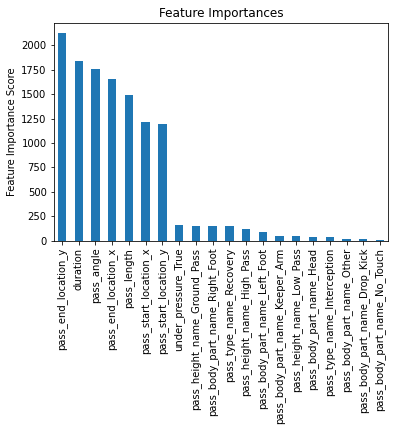

In [38]:
xgb2 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 150,
    max_depth = 8,
    min_child_weight = 4,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = scale_pos_weight,
    seed = 27,
    use_label_encoder = False)
modelfit(xgb2, X_train, X_test, y_train, y_test)

X_test = X_test.drop([x for x in ['predprob'] if x in X_test.columns], axis=1)

Теперь определим 'subsample' и 'colsample_bytree'

In [44]:
param_test_4 = {
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)]
}
gsearch_4 = GridSearchCV(estimator = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 150,
    max_depth = 8,
    min_child_weight = 4,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = scale_pos_weight,
    seed = 27,
    use_label_encoder = False), param_grid = param_test_4, scoring = 'roc_auc', n_jobs = 4, cv=5)

gsearch_4.fit(X_train, y_train)

[02:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=8, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None,
                

In [45]:
list(zip(gsearch_4.cv_results_['mean_test_score'], gsearch_4.cv_results_['params']))

[(0.9367623112106169, {'colsample_bytree': 0.6, 'subsample': 0.6}),
 (0.9370132642357124, {'colsample_bytree': 0.6, 'subsample': 0.7}),
 (0.9370113169078284, {'colsample_bytree': 0.6, 'subsample': 0.8}),
 (0.9370246018779556, {'colsample_bytree': 0.6, 'subsample': 0.9}),
 (0.9369651826136727, {'colsample_bytree': 0.7, 'subsample': 0.6}),
 (0.9368919187088327, {'colsample_bytree': 0.7, 'subsample': 0.7}),
 (0.9369513735966667, {'colsample_bytree': 0.7, 'subsample': 0.8}),
 (0.9371141785945432, {'colsample_bytree': 0.7, 'subsample': 0.9}),
 (0.9370313416363791, {'colsample_bytree': 0.8, 'subsample': 0.6}),
 (0.9371646552788905, {'colsample_bytree': 0.8, 'subsample': 0.7}),
 (0.9371982087388517, {'colsample_bytree': 0.8, 'subsample': 0.8}),
 (0.9370685003175765, {'colsample_bytree': 0.8, 'subsample': 0.9}),
 (0.936895393811769, {'colsample_bytree': 0.9, 'subsample': 0.6}),
 (0.9372975262931428, {'colsample_bytree': 0.9, 'subsample': 0.7}),
 (0.9372274752836984, {'colsample_bytree': 0.9, '

In [46]:
print('The best parameters:', gsearch_4.best_params_)
print('The best score:', gsearch_4.best_score_)

The best parameters: {'colsample_bytree': 0.9, 'subsample': 0.7}
The best score: 0.9372975262931428


Лучшие значения получили на 'colsample_bytree' = 0.9, 'subsample' = 0.7. Теперь попробуем значения, близкие к полученным параметрам и отличающиеся на 0.05

In [47]:
param_test_5 = {
    'subsample': [i / 100.0 for i in range(65, 80, 5)],
    'colsample_bytree': [i / 100.0 for i in range(85, 100, 5)]
}
gsearch_5 = GridSearchCV(estimator = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 150,
    max_depth = 8,
    min_child_weight = 4,
    gamma = 0,
    subsample = 0.7,
    colsample_bytree = 0.9,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = scale_pos_weight,
    seed = 27,
    use_label_encoder = False), param_grid = param_test_5, scoring = 'roc_auc', n_jobs = 4, cv=5)

gsearch_5.fit(X_train, y_train)

[02:59:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=8, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None,
                

In [48]:
list(zip(gsearch_5.cv_results_['mean_test_score'], gsearch_5.cv_results_['params']))

[(0.9371617454536901, {'colsample_bytree': 0.85, 'subsample': 0.65}),
 (0.937230417270618, {'colsample_bytree': 0.85, 'subsample': 0.7}),
 (0.9372132563806026, {'colsample_bytree': 0.85, 'subsample': 0.75}),
 (0.9370906421738063, {'colsample_bytree': 0.9, 'subsample': 0.65}),
 (0.9372975262931428, {'colsample_bytree': 0.9, 'subsample': 0.7}),
 (0.9370269854955883, {'colsample_bytree': 0.9, 'subsample': 0.75}),
 (0.9372368673034421, {'colsample_bytree': 0.95, 'subsample': 0.65}),
 (0.9372012024342965, {'colsample_bytree': 0.95, 'subsample': 0.7}),
 (0.9371457907752241, {'colsample_bytree': 0.95, 'subsample': 0.75})]

In [49]:
print('The best parameters:', gsearch_5.best_params_)
print('The best score:', gsearch_5.best_score_)

The best parameters: {'colsample_bytree': 0.9, 'subsample': 0.7}
The best score: 0.9372975262931428


Поставим 'colsample_bytree' = 0.9, 'subsample' = 0.7. Посчитаем промежуточное улучшение


Model Report
Accuracy : 0.875
AUC Score (Train): 0.948558
AUC Score (Test): 0.939924


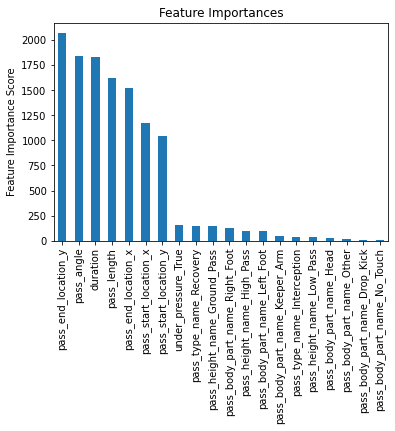

In [50]:
xgb3 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 150,
    max_depth = 8,
    min_child_weight = 4,
    gamma = 0,
    subsample = 0.7,
    colsample_bytree = 0.9,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = scale_pos_weight,
    seed = 27,
    use_label_encoder = False)
modelfit(xgb3, X_train, X_test, y_train, y_test)

X_test = X_test.drop([x for x in ['predprob'] if x in X_test.columns], axis=1)

Подберём параметр регуляризации 'reg_alpha'

In [51]:
param_test_6 = {
    'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 100]
}
gsearch_6 = GridSearchCV(estimator = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 150,
    max_depth = 8,
    min_child_weight = 4,
    gamma = 0,
    subsample = 0.7,
    colsample_bytree = 0.9,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = scale_pos_weight,
    seed = 27,
    use_label_encoder = False), param_grid = param_test_6, scoring = 'roc_auc', n_jobs = 4, cv=5)

gsearch_6.fit(X_train, y_train)

[03:16:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=8, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None,
                

In [52]:
list(zip(gsearch_6.cv_results_['mean_test_score'], gsearch_6.cv_results_['params']))

[(0.9372975262931428, {'reg_alpha': 0}),
 (0.9372975245030337, {'reg_alpha': 1e-05}),
 (0.9372364983864461, {'reg_alpha': 0.01}),
 (0.9372692789566155, {'reg_alpha': 0.1}),
 (0.9372220354356431, {'reg_alpha': 1}),
 (0.9292549272396636, {'reg_alpha': 100})]

In [53]:
print('The best parameter:', gsearch_6.best_params_)
print('The best score:', gsearch_6.best_score_)

The best parameter: {'reg_alpha': 0}
The best score: 0.9372975262931428


Лучшее значение при 'reg_alpha' = 0, каким оно и было до этого (default value).

Уменьшим learning_rate и добавим больше n_estimators


Model Report
Accuracy : 0.8755
AUC Score (Train): 0.948991
AUC Score (Test): 0.940613


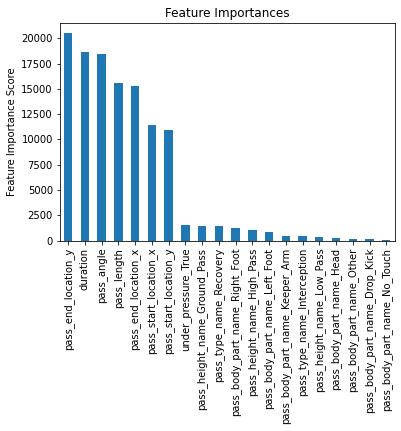

In [60]:
xgb4 = XGBClassifier(
    learning_rate = 0.01,
    n_estimators = 1500,
    max_depth = 8,
    min_child_weight = 4,
    gamma = 0,
    subsample = 0.7,
    colsample_bytree = 0.9,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = scale_pos_weight,
    seed = 27,
    use_label_encoder = False)
modelfit(xgb4, X_train, X_test, y_train, y_test)

X_test = X_test.drop([x for x in ['predprob'] if x in X_test.columns], axis=1)

В качестве предсказывающей модели возьмём xgb4.

Установим предсказываемую выборку:

In [61]:
X_predict = df_predict[df_predict['id'].isin(submission_result['id'])]
X_predict = X_predict.sort_values(by=['id'])
ID_col = X_predict['id']
X_predict = set_X(X_predict)
X_predict

,pass_start_location_x,pass_start_location_y,pass_end_location_x,pass_end_location_y,pass_length,pass_angle,duration,pass_height_name_Ground_Pass,pass_height_name_High_Pass,pass_height_name_Low_Pass,pass_body_part_name_Drop_Kick,pass_body_part_name_Head,pass_body_part_name_Keeper_Arm,pass_body_part_name_Left_Foot,pass_body_part_name_No_Touch,pass_body_part_name_Other,pass_body_part_name_Right_Foot,pass_type_name_Interception,pass_type_name_Recovery,under_pressure_True
30907,51.4,76.6,51.0,73.4,3.224903,-1.695151,0.292576,1,0,0,0,0,0,0,0,0,1,0,0,0
217239,56.8,11.8,62.1,26.9,16.003124,1.233237,0.760978,0,0,1,0,1,0,0,0,0,0,0,0,0
142929,47.0,15.3,50.8,9.3,7.102112,-1.006227,0.878056,1,0,0,0,0,0,0,0,0,1,0,0,0
206533,53.5,46.3,62.9,66.9,22.643322,1.142707,1.693729,1,0,0,0,0,0,0,0,0,1,0,0,0
140633,4.0,65.1,5.1,79.8,14.741099,1.496106,0.718867,1,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168732,86.5,48.9,92.5,29.9,19.924858,-1.264917,1.138756,1,0,0,0,0,0,0,0,0,1,0,0,0
221509,36.7,72.1,45.0,75.4,8.931965,0.378427,1.033124,0,0,1,0,0,0,0,0,0,0,0,1,1
163765,26.2,65.5,34.7,53.5,14.705441,-0.954499,1.273254,1,0,0,0,0,0,0,0,0,1,0,0,0
151643,90.6,66.8,91.8,52.6,14.250614,-1.486490,0.919018,0,1,0,0,1,0,0,0,0,0,0,1,0


In [62]:
data = {
    'id': ID_col
}
predictions = pd.DataFrame(data)
predictions_probability = pd.DataFrame(data)

predictions['outcome_binary'] = xgb4.predict(X_predict)
predictions_probability['outcome_binary'] = xgb4.predict_proba(X_predict)[:,1]

In [63]:
predictions

,id,outcome_binary
30907,00008169-659b-46c5-be86-a15b8068ef05,0
217239,0000c881-3d53-4c2f-86bb-542b653591ae,0
142929,00010f78-4407-4e0c-b59e-a33f3b86af1f,1
206533,000186c5-94e1-46ab-90b8-4b20ba319d1b,1
140633,0002d42e-6214-48fa-ba7d-2ade486dcd27,0
...,...,...
168732,fffbc079-230d-4eb6-b713-9509b07dd02d,1
221509,fffce801-575e-4f51-8411-5fa1a338360d,0
163765,fffd0d33-a248-4fc8-8ef0-edaa4d4cc217,1
151643,fffd4e83-cae7-4146-8729-ab37a74f7e18,0


In [64]:
predictions_probability

,id,outcome_binary
30907,00008169-659b-46c5-be86-a15b8068ef05,0.016934
217239,0000c881-3d53-4c2f-86bb-542b653591ae,0.428775
142929,00010f78-4407-4e0c-b59e-a33f3b86af1f,0.915592
206533,000186c5-94e1-46ab-90b8-4b20ba319d1b,0.945561
140633,0002d42e-6214-48fa-ba7d-2ade486dcd27,0.055394
...,...,...
168732,fffbc079-230d-4eb6-b713-9509b07dd02d,0.713262
221509,fffce801-575e-4f51-8411-5fa1a338360d,0.472454
163765,fffd0d33-a248-4fc8-8ef0-edaa4d4cc217,0.932571
151643,fffd4e83-cae7-4146-8729-ab37a74f7e18,0.213666


In [65]:
# Это предсказания!
predictions.to_csv('predictions/predictions.csv', index=False)

# Это вероятности!
predictions_probability.to_csv('predictions/predictions_probability.csv', index=False)